<a href="https://colab.research.google.com/github/sravyamullapudi26/fmml-lab-1/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-13 07:57:13--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.75, 18.239.225.61, 18.239.225.55, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  88.8MB/s    in 0.5s    

2024-05-13 07:57:14 (88.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


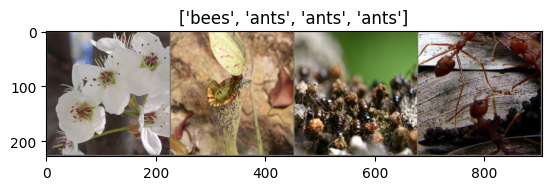

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.8MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5147 Acc: 0.7459

Epoch 1/4
----------
Loss: 0.5053 Acc: 0.7869

Epoch 2/4
----------


In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


Data augmentation techniques like resizing, cropping, flipping, rotating, and adding noise to training data serve several significant purposes in machine learning, particularly in tasks involving computer vision and deep learning:

1. **Increased Training Data**: Data augmentation artificially expands the size of the training dataset by creating modified versions of existing samples. This helps in overcoming issues related to limited data availability, especially in scenarios where collecting more data is challenging or expensive.

2. **Improved Generalization**: By exposing the model to a variety of augmented versions of the original data, data augmentation encourages the model to learn more robust and invariant features. This leads to improved generalization performance on unseen or slightly different data during testing or deployment.

3. **Regularization**: Data augmentation acts as a form of regularization by introducing noise and variability into the training process. This helps in preventing the model from overfitting to the training data and encourages it to learn more generalized patterns.

4. **Translation Invariance**: Techniques like cropping and random translations help the model become invariant to translations in the input data. This is especially important in tasks where the position or orientation of objects in images can vary.

5. **Rotation and Scale Invariance**: Rotating and scaling images during data augmentation help the model learn features that are invariant to rotations and changes in scale, making the model more robust to variations in object orientation and size.

6. **Reducing Bias**: Data augmentation can help mitigate biases present in the original dataset. For example, if the original dataset predominantly contains images with objects centered, augmenting the data with random crops or translations can introduce diversity and reduce bias towards centered objects.

7. **Domain Adaptation**: In scenarios where the distribution of training data differs from the distribution of test data (domain shift), data augmentation techniques can help bridge this gap by making the model more adaptable to variations encountered in real-world scenarios.

Overall, data augmentation is a powerful technique that plays a crucial role in improving model performance, robustness, and generalization ability, especially when training data is limited or when dealing with complex and diverse datasets.

If you don't use a pretrained ResNet model and instead train the model from scratch (i.e., setting `pretrained=False`), the performance of the model is likely to be lower compared to using a pretrained model. Here are a few reasons why:

1. **Feature Learning**: Pretrained models like ResNet have already learned rich and generalized features from a large dataset (such as ImageNet). Training from scratch means the model has to learn these features from scratch using your smaller dataset. This can be challenging, especially if your dataset is limited, leading to suboptimal feature representations.

2. **Generalization**: Pretrained models are better at generalizing to unseen data due to the diverse nature of the data they were trained on. Training from scratch might result in a model that is more tailored to the training data but might not generalize well to new or slightly different data.

3. **Computational Cost**: Training a deep neural network like ResNet from scratch can be computationally expensive and time-consuming, especially if you have limited computational resources or time constraints.

4. **Overfitting Risk**: Without the regularization effect of pretrained weights, there's a higher risk of overfitting, especially when dealing with small datasets. Pretrained models act as a form of regularization by providing a good initialization point for the model parameters.

5. **Hyperparameter Tuning**: Training from scratch often requires extensive hyperparameter tuning to achieve good performance. This includes tuning learning rates, regularization techniques, network architecture, and optimization algorithms, which can be challenging without the guidance of pretrained weights.

In summary, using a pretrained ResNet model typically leads to better performance, faster convergence, and improved generalization compared to training from scratch, especially when dealing with small datasets. However, training from scratch can still be viable if you have specific constraints or requirements that necessitate doing so, such as a dataset that is highly specialized and significantly differs from the data used to pretrain the model.

Using a pretrained ResNet model that was trained on a dataset significantly different from the ants vs. bees dataset can still yield good performance, but there are several considerations to keep in mind:

1. **Feature Transferability**: Pretrained models, especially those trained on large and diverse datasets like ImageNet, learn general features that are transferable across different domains. These features often include low-level features like edges and textures as well as higher-level features like object parts and shapes. Even though the original dataset may be different, these general features can still be useful for tasks like image classification.

2. **Fine-Tuning**: To adapt a pretrained model to a new dataset (such as ants vs. bees), fine-tuning is typically necessary. Fine-tuning involves updating the weights of the pretrained model using the new dataset while retaining most of the learned features. By fine-tuning, the model can adjust its learned representations to better suit the characteristics of the new dataset, potentially leading to improved performance.

3. **Domain Adaptation**: If the differences between the original pretrained dataset and the target dataset (ants vs. bees) are significant, additional techniques for domain adaptation may be beneficial. These techniques aim to bridge the domain gap between the datasets and improve the transferability of features. Examples include data augmentation, domain-specific regularization, and adversarial training.

4. **Evaluation and Tuning**: When using a pretrained model on a new dataset, it's important to evaluate the model's performance on validation data and possibly perform hyperparameter tuning. This includes adjusting learning rates, dropout rates, and other model-specific parameters to achieve optimal performance.

5. **Task Similarity**: The success of using a pretrained model also depends on the similarity of the tasks between the original dataset and the target dataset. If the tasks are related (e.g., both involve image classification), the pretrained model's features are more likely to be relevant and beneficial.

In summary, while using a pretrained ResNet model on a significantly different dataset like ants vs. bees can still yield good performance, additional steps such as fine-tuning and domain adaptation may be necessary to maximize the model's effectiveness and adapt it to the new dataset's characteristics.